# Code for fitting Astro RC data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 
import pandas as pd
import pystan

import os
import pickle

els = False

import sys

In [3]:
def read_data():
    sfile = '../data/KepxDR2/rcxyu18.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

def read_trilegal():
    tdf = pd.read_csv('../data/TRILEGAL_sim/k1.6b_K15b30_0910_new.all.out.txt',sep='\s+')
    tdf['Ak'] = omnitool.literature_values.Av_coeffs['Ks'].values[0]*tdf.Av
    tdf['MK'] = tdf.Ks - tdf['m-M0'] - tdf.Ak
    tdf['dist'] = 10.0**(tdf['m-M0'] / 5.0 + 1.0)
    tdf['parallax'] = 1./tdf.dist
    return tdf[tdf.stage==5]  

def read_data_wtgas():
    sfile = '../data/KepxDR2/MRCxyu18_wdupes_BC.csv'
    yu18 = pd.read_csv(sfile)
    sfile = '/home/oliver/PhD/Catalogues/APOKASC/APOKASC_cat_v3.6.5.txt'
    cols= ['KEPLER_ID','GAIA_PARALLAX','GAIA_PARALLAX_ERR']
    apokasc = pd.read_csv(sfile, usecols=cols, skiprows=644,sep='\s+')
    apokasc.rename(columns={'KEPLER_ID':'KICID'},inplace=True)

    #Now lets combine and make cuts
    print('X-matching Yu18xAPOKASC and Gaia Data')
    print('Before: '+str(len(yu18)))
    df = pd.merge(yu18, apokasc, on='KICID',how='outer').reindex()
    df = df[~df.numax.isnull()].reindex()

    df = df[~df.GAIA_PARALLAX.isnull()].reindex()
    df = df[df.GAIA_PARALLAX > -9000.].reindex()
    df = df[df.GAIA_PARALLAX_ERR/df.GAIA_PARALLAX < .3].reindex()

    print('After: '+str(len(df)))
    
    sg = omnitool.spyglass()
    sg.pass_parallax(df.GAIA_PARALLAX, err = df.GAIA_PARALLAX_ERR)
    sg.pass_position(df.ra, df.dec, frame='icrs')    
    sg.pass_magnitude(df.kmag, band='Ks')
    df['TGAS_MKs'], df['TGAS_MKs_err'] = sg.get_M()
    df = df[~df.TGAS_MKs.isnull()].reindex()    
    
    return df
    
def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [4]:
df = read_data()
print('Size: '+str(len(df)))
df.head(2)

Size: 7497


,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,fwhm,...,BC_GBP,BC_GRP,BC_J,BC_H,BC_K,ast_MKs,ast_MH,ast_MJ,ast_MG,ast_M_err
KICID,,,,,,,,,,,,,,,,,,,,,
892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,12.0,...,-0.740,0.388,1.206,1.638,1.766,-1.671046,-1.543046,-1.111046,0.343954,0.206767
1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,24.8,...,-0.754,0.409,1.252,1.706,1.840,-1.878376,-1.744376,-1.290376,0.205624,0.166498


## Stan model for astrometric values

In [5]:
overwrite = True
asterostan = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;
    real m[N];
    real<lower=0> m_err[N];
    real oo_uncorr[N];
    real oo_err[N];
    real<lower=0> RlEbv[N];
    real oo_zp;
}
transformed data{
    real oo[N];
    for (n in 1:N)
        oo[n] = oo_uncorr[n] - oo_zp;
}
parameters {
    //Hyperparameters
    real mu;
    real<lower=0.> sigma;
    real<lower=0.3> sigo;
    real<lower=0.,upper=1.> Q;
    real<lower=.1, upper=4000.> L;
    
    //Latent parameters
    real M_infd_std[N];
    real Ai[N];
    real<lower = 1.> r_infd[N];
}
transformed parameters{
    //Inferred and transformed parameters
    real M_infd[N];
//    real tsigo;
    
    //Operations
    for (n in 1:N){
        M_infd[n] = mu + M_infd_std[n]; //Rescale the M fit
    }
//    tsigo = sigo / sigma;
}
model {
    //Define calculable properties
    real m_true[N];
    real oo_true[N];
    
    //Hyperparameters in true space [p(theta_rc, L)]
    mu ~ normal(-1.7, .1);
    sigma ~ normal(.1, .05);
    Q ~ uniform(0., 1.);
    sigo ~ normal(1.5, .5);
    L ~ uniform(0.1, 4000.);
    
    //Latent parameters [p(alpha_i | theta_rc, L)]
    Ai ~ normal(RlEbv, 0.03);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., sigma),
            normal_lpdf(M_infd_std[n] | 0., sigo));
    }
    
    //Calculable properties
    for (n in 1:N){
        m_true[n] = M_infd[n] + 5*log10(r_infd[n]) - 5 + Ai[n];
        oo_true[n] = 1000./r_infd[n];
    }

    //Observables [p(D | theta_rc, L, alpha)]
    oo ~ normal(oo_true, oo_err); //Measurement uncertainty on parallax
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
}

'''

model_path = 'astrostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='astrostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='astrostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)
print('Completed')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL astrostan_2acf434f54b76f8d2737bd18b96a7666 NOW.


Updating Stan model
Completed


#### Run the model

In [6]:
sel = df[:1000]
m = sel.Kmag.values
m_err = sel.e_Kmag.values
oo = sel.parallax.values
oo_err = sel.parallax_error.values
oo_zp = -0.029
RlEbv = sel.Aks.values

dat = {'N': len(sel),
        'm': m,              #Magnitude in given band
        'm_err' : m_err,     #Magnitude error
        'oo_uncorr' : oo,       #Observed parallax
        'oo_err' : oo_err,   #Observed parallax error
        'RlEbv':RlEbv,
        'oo_zp':oo_zp}       #Reddening
        

initd = {'mu':-1.7,        #Red clump position
        'sigma':0.05,         #Red clump spread
        'Q': 0.8,           #Mixture model weighting factor
        'sigo':.7}           #Spread of outlier distribution

fit = sm.sampling(data=dat, iter=2000, chains=2, init=[initd,initd])

//anaconda/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


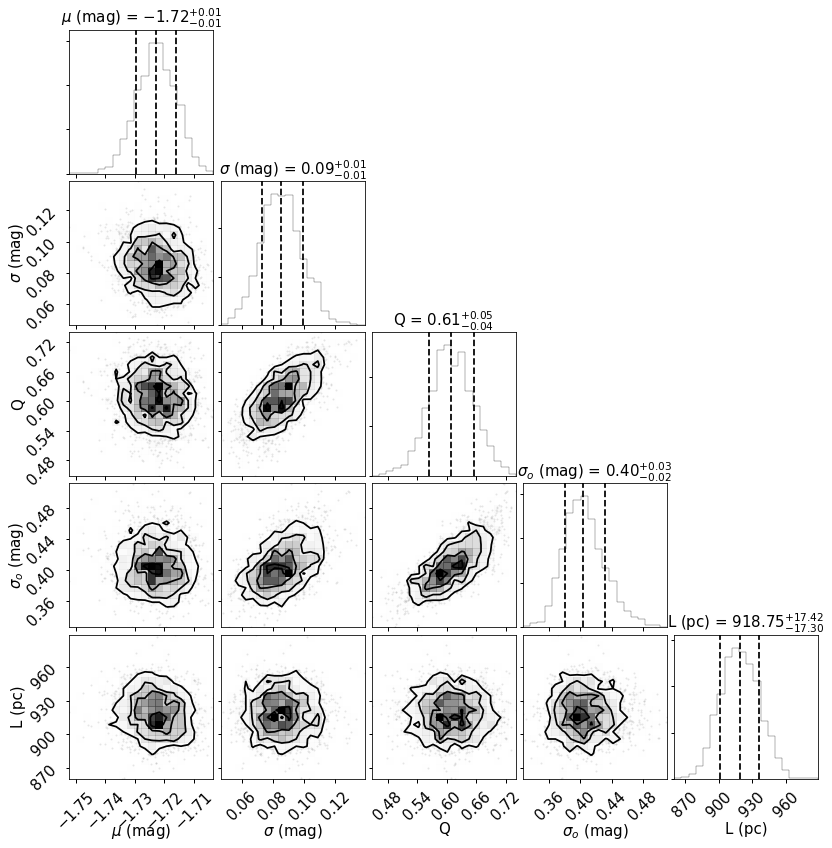

In [7]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo'],fit['L']])
corner.corner(chain.T,\
                labels=[r'$\mu$ (mag)',r'$\sigma$ (mag)','Q',r'$\sigma_o$ (mag)','L (pc)'],\
                quantiles=[0.16, 0.5, 0.84],\
                show_titles=True, title_kwargs={"fontsize": 15})
plt.show()

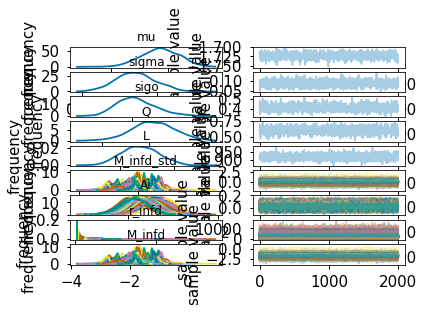

In [8]:
fit.plot()
plt.show()

In [9]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])
Minfd = np.median(fit['M_infd'],axis=0)
rinfd = np.median(fit['r_infd'],axis=0)
Linfd = np.median(fit['L'],axis=0)

fg = normal(Minfd, mu, sigma)
bg = normal(Minfd, mu, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

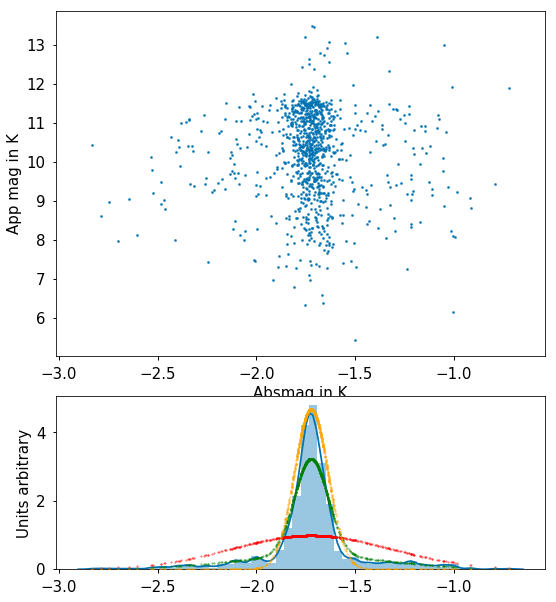

In [10]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

c = sax.scatter(Minfd,m,s=5,zorder=1000)

sns.distplot(Minfd,ax=xax)

xax.scatter(Minfd,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(Minfd,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(Minfd, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

The above plot compares the inferred absolute Kband magnitude to the observed absolute Kband magnitude--- there are more data points at the red clump overdensity which is expected, as the points will have been placed there within the constraints of the observational uncertainties. 

There appears to be some kind of offset still, as there appears to be some correlation around the bisector at the inferred absolute magnitude positions.

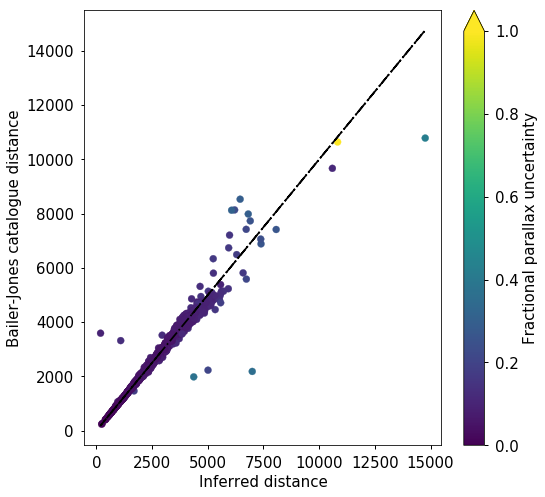

Our L: 918.7502857990537
BJ+18 median L: 1450.245727631075


In [11]:
fig, ax = plt.subplots(figsize=(8,8))
f = np.abs(sel.parallax_error/sel.parallax)
c = plt.scatter(sel.r_est,rinfd,c=f, vmin=0., vmax=1.)
fig.colorbar(c, label='Fractional parallax uncertainty',extend='max')
ax.plot(sel.r_est, sel.r_est,c='k',linestyle='-.')
ax.set_xlabel('Inferred distance')
ax.set_ylabel('Bailer-Jones catalogue distance')
plt.show()
print('Our L: '+str(Linfd))
print('BJ+18 median L: '+str(np.median(sel.r_length_prior)))

Given that our L is smaller, we expect the mode of the prior distribution to be at a **lower distance**, and therefore we expect stars with high fractional uncertainties to be have a **lower inferred distance**. This means we would expect high fractional uncertainty stars to be *below* the bisector. That appears to be the case, although we'll need to run on more stars to confirm.

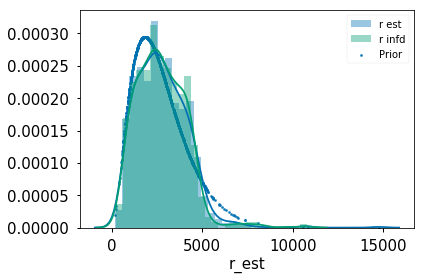

In [12]:
r = sel.r_est
prior = (1/(2*Linfd**3)) * (r*r) * np.exp(-r/Linfd)

sns.distplot(sel.r_est,label='r est')
sns.distplot(rinfd, label='r infd')
plt.scatter(r,prior,s=5,label='Prior')
plt.legend()
plt.show()

From this it looks like the best fit value of L does not comply well for the full dataset--- could this be because L varies as a function of galactic position?

Total number of Rhats: 4006
Total number of Rhats with the NaN values removed: 4006


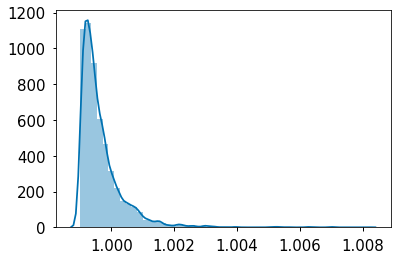

In [13]:
s = fit.summary()
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

In [14]:
print(fit)

Inference for Stan model: astrostan_2acf434f54b76f8d2737bd18b96a7666.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.72  2.1e-4 6.8e-3  -1.74  -1.73  -1.72  -1.72  -1.71 1051.0    1.0
sigma             0.09  9.0e-4   0.01   0.06   0.08   0.09   0.09   0.11  221.0    1.0
sigo              0.41  8.8e-4   0.03   0.36   0.39    0.4   0.42   0.47  924.0    1.0
Q                 0.61  2.1e-3   0.05   0.52   0.58   0.61   0.64    0.7  448.0    1.0
L               919.04    0.38  17.16 887.14  907.2 918.75  930.8 952.58 2000.0    1.0
M_infd_std[0]     0.18  2.2e-3    0.1 1.7e-3    0.1   0.17   0.25   0.38 2000.0    1.0
M_infd_std[1]    -0.27  2.9e-3   0.13  -0.52  -0.37  -0.28  -0.18  -0.04 2000.0    1.0
M_infd_std[2]    -0.07  1.5e-3   0.07  -0.21  -0.11  -0.06  -0.02   0.06 2000.0    1.0
M_infd_std[3]    -0.09  2.7e-

### Temporarily redundant code

In [14]:
sys.exit()

SystemExit: 

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
L = 1000.
r = np.linspace(0.1,8000, 100000)
p = (1/(2*L**3))*(r*r) * exp(-r/L)
print(p)
plt.plot(r, p)
plt.show()

In [ ]:
'''    //Hyperparameter Uniform priors for testing
        mu ~ uniform(-2., -1.);
        sigma ~ uniform(0.01, .15);
        Q ~ uniform(.8, 1.);
        muo ~ uniform(-2, -1.);
        sigo ~ normal(1.5, .5);
        L ~ uniform(0.1, 4000.);
'''

In [ ]:
plt.scatter(df.Ak_bj, df.Ak_pl)
plt.plot(df.Ak_bj,df.Ak_bj,label='Bisector',c='k',linestyle='-.')
plt.plot(df.Ak_bj,df.Ak_bj+0.05, label='+0.05mag',c='k',linestyle='-.')
plt.plot(df.Ak_bj,df.Ak_bj-0.05, label='-0.05mag',c='k',linestyle='-.')
plt.legend()
plt.xlabel('Extinction in K using Bailerjones')
plt.ylabel('Extinction in K using 1/parallax')
plt.show()

In [ ]:
'''Now lets quickly compare the inferred value of M and the omnitool value'''
fig, ax = plt.subplots(figsize=(8,8))
f = np.abs(sel.parallax_error/sel.parallax)
c= ax.scatter(sel.phot_MKs, Minfd,zorder=2,c=f,vmin=0.,vmax=1.)
fig.colorbar(c, label='Fractional parallax uncertainty',extend='max')
ax.errorbar(sel.phot_MKs, Minfd,xerr=sel.phot_MKs_err,c='grey',fmt='none',alpha=.3,zorder=1)
ax.plot(sel.phot_MKs, sel.phot_MKs, c='k',linestyle='-.')
ax.set_xlabel('Measured photometric absmag')
ax.set_ylabel('Inferred absmag')
plt.show()